In [1]:
import sys
sys.version

'3.5.2 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:52:12) \n[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]'

In [38]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn


In [133]:
from datetime import datetime


random.seed(100)
datapath = "/Users/tuanle/DynamicPricing/Data/"
Ha_Noi = pd.read_csv(datapath+"HAN-BIKE_3month_CompletedOrders.csv")
# Ha_Noi = pd.read_csv(datapath+"OnlineDrivers_HaNoi_10days.csv")

#Add an additional column into the table
# sLength = len(Ha_Noi['accept_rate'])
# Ha_Noi['completed_ordersT'] = pd.Series(Ha_Noi['completed_orders'], index=Ha_Noi.index)
#Shift the entries in the accept_rate column upward
Ha_Noi.completed_orders = Ha_Noi.completed_orders.shift(-1)
#Drop all the "na" entries in the original table
Ha_Noi = Ha_Noi.dropna(subset = ["completed_orders"])

df2 = pd.DataFrame(Ha_Noi)
df2['completed_orders'].describe()
df2['date'] = df2['hourr'].astype(str) + ":" + df2['to_char']

df2 = df2.drop(df2.columns[[0,1]], axis=1)

from datetime import datetime
df2['date'] =  pd.to_datetime(df2['date'], format='%H.%f:%Y/%M/%d')
# df2 = df2.drop(df2.columns[[0]], axis = 1)
df2['date'] =df2['date'].astype(str)
df2['completed_orders'].describe()

df2['completed_orders'].describe()














count    1713.000000
mean      183.525394
std       102.980068
min         6.000000
25%       106.000000
50%       173.000000
75%       246.000000
max       595.000000
Name: completed_orders, dtype: float64

In [ ]:
DF2 = np.array(df2['completed_orders'])
num_periods = 10 #number of periods per vector we are using to predict one period ahead
f_horizon = 1

x_data = DF2[:(len(DF2)- (len(DF2) % num_periods))]
x_batches = x_data.reshape(-1, 10, 1)

y_data = DF2[1:(len(DF2) - (len(DF2) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1,10,1)

# x_data2 = DF3[:(len(DF3)- (len(DF3) % num_periods))]
# x_batches2 = x_data2.reshape(-1, 10, 1)

# y_data2 = DF3[:(len(DF3)- (len(DF3) % num_periods)) + f_horizon]
# y_batches2 = y_data2.reshape(-1,10,1)

# print(len(x_batches))
# print(x_batches.shape)
# # print(x_batches[0:2])

def test_data(series, forecast, num_periods):
    test_X_setup = series[-(num_periods + forecast):]
    testX = test_X_setup[:num_periods].reshape(-1,10,1)
    testY = series[-(num_periods):].reshape(-1,10,1)
    return testX, testY

X_test, Y_test = test_data(DF2, f_horizon, num_periods)

tf.reset_default_graph() #This helps reset the graph everytime we re-run our program

inputs = 1 #number of vectors submitted
hidden = 300 #number of neurons we will recursively work through
output = 1  #number of output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs]) #create variable object
Y = tf.placeholder(tf.float32, [None, num_periods, output])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units = hidden, activation = tf.nn.relu) #create our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype = tf.float32) #choose dynamic over static

learning_rate = 0.001 #small rate so we don't overshoot minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden]) #change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output) #specify the type of layer
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output]) #shape of results


loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(outputs, Y))) #define the cost function
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate) #Gradient Descent Method
training_op = optimizer.minimize(loss) #train the result of the application of the lost function

init = tf.global_variables_initializer() #initialize all the variables

#train the model
epochs = 2000 #number of iterations we train our model, using both forward and backward propagation

with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict = {X: x_batches, Y: y_batches})
        if ep % 100 == 0:
            rmse = loss.eval(feed_dict = {X: x_batches, Y: y_batches})
#             print(ep, "\tRMSE:", rmse)
        
        ypred = sess.run(outputs, feed_dict = {X: X_test})
        print(ypred)
        print(ep, "\tRMSE:", loss.eval(feed_dict = {outputs: ypred, Y: Y_test}))














[[[-15.29372692]
  [ 14.73064232]
  [ 16.3233242 ]
  [ 14.67075729]
  [  9.06827354]
  [  2.2465024 ]
  [ -0.85092312]
  [  4.2649374 ]
  [  9.65339661]
  [ 24.92958832]]]
0 	RMSE: 150.37
[[[-11.49433041]
  [ 32.39556885]
  [ 37.38741302]
  [ 36.25749588]
  [ 26.44565773]
  [ 16.58730316]
  [ 15.2799921 ]
  [ 25.07870102]
  [ 36.74175262]
  [ 54.04741669]]]
1 	RMSE: 137.781
[[[ -7.78160715]
  [ 49.20169067]
  [ 59.05847549]
  [ 60.66368866]
  [ 46.39926147]
  [ 35.80718231]
  [ 34.88825226]
  [ 49.45553589]
  [ 67.53100586]
  [ 86.58744049]]]
2 	RMSE: 125.572
[[[  -4.13450003]
  [  65.37770844]
  [  81.31156158]
  [  88.26300812]
  [  72.86987305]
  [  64.39395905]
  [  63.99063873]
  [  82.06814575]
  [ 106.79772186]
  [ 128.01882935]]]
3 	RMSE: 113.846
[[[  -0.52695608]
  [  81.25310516]
  [ 105.37635803]
  [ 119.35946655]
  [ 108.10364532]
  [ 105.23110962]
  [ 111.43310547]
  [ 133.19671631]
  [ 163.73913574]
  [ 188.35264587]]]
4 	RMSE: 107.21
[[[   3.01610184]
  [  96.58628845]
 

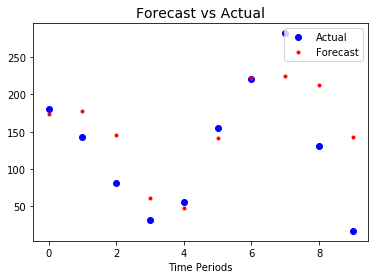

In [134]:
plt.title("Forecast vs Actual", fontsize = 14)
plt.plot(pd.Series(np.ravel(Y_test)), "bo",  label = "Actual")
plt.plot(pd.Series(np.ravel(ypred)), "r.",  label = "Forecast")
plt.legend(loc = "upper right")
plt.xlabel("Time Periods")

plt.show()